In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import scipy.io as sio
from scipy.stats import bernoulli
import scipy.stats as stats
import os
from mpl_toolkits.axes_grid.inset_locator import inset_axes

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_34139/3180411627.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [2]:
# compute discrete integral
def compute_probs(trgt_pred):
    for col in [0,2]:
        probs = [0]
        integ = 0    
        i = 0
        
        while i < (len(trgt_pred)-2):                    
            # for short and long exposure time
            area = (trgt_pred.iloc[i + 1,col] - trgt_pred.iloc[i,col]) * trgt_pred.iloc[i + 1, col+1] 
            integ = area + integ
            probs.append(area)
        
            i = i + 1

        # Here complete it to 1, check it again
        probs.append((1-np.sum(probs)))

        if col == 0:
            trgt_pred['prob_short'] = probs
        else:
            trgt_pred['prob_long'] = probs

def normalize(data):    
    output = (data - np.min(data))/ (np.max(data) - np.min(data))
    return output

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post')
    plt.grid(True)
    plt.savefig('ecdf.png')


def find_closest_number(arr, num):
    idx = np.abs(arr - num).argmin()
    return idx

In [3]:
# Seg Size, Seg Dist.
logLikeShort = {'re':[-2.994435716049892e+02, -3.030639587322882e+02], 'js':[-2.629125297671579e+02, -2.580571857293443e+02], 'mae':[-3.113659868817745e+02, -3.033973914918880e+02], 'go':[-3.276282525606540e+02, -3.317093393293803e+02], 'eb':[-2.961080463077027e+02, -3.006439215475571e+02], 'da':[-2.388514890237365e+02, -2.502479760370769e+02]}
logLikeLong = {'re':[-2.490408479963941e+02, -2.458965211686789e+02], 'js':[-1.332527352862930e+02, -1.345071718378993e+02], 'mae':[-2.580803463410833e+02, -2.520884125798174e+02], 'go':[-2.988568362978489e+02, -3.061079660925760e+02], 'eb':[-2.524998555891823e+02, -2.550164533399188e+02], 'da':[-2.460770775429795e+02, -2.459332038133498e+02]}
# short, long
logLikeCutNo = {'re':[-2.962807343410386e+02, -2.446601835732627e+02], 'js':[-2.486337257787215e+02, -1.292762218298185e+02], 'mae':[-2.969293753074582e+02, -2.503879272088506e+02], 'go':[-3.292355321241545e+02, -3.028743130648386e+02], 'eb':[-2.968517584897348e+02, -2.538781300509378e+02], 'da':[-2.506164506187192e+02, -2.468436100510789e+02]}

# Model Comparison

In [4]:
dev = {'id':['da','eb','go','js','mae','re',
             'da','eb','go','js','mae','re',

             'da','eb','go','js','mae','re',
             'da','eb','go','js','mae','re',

             'da','eb','go','js','mae','re',
             'da','eb','go','js','mae','re',], 
       'dev':[2.129649784503854, 1.789677124711972, 2.992209755082840, 5.158675437577216, 11.625853013877546, 5.568004186405332,
              0.888910549504601, 2.708335142224044, 2.392561990969014, 2.308922115276356, 0.867519855572823 ,1.345644720680511,
                    
              61.861684034400840,55.458214690114225, 40.793234312571280, 52.017167555616986, 63.424209211049850, 29.428669097152365,
              34.814684816748620, 73.182501301722430, 44.251363425697015, 36.183203211748285, 54.302289571067300, 22.137769600548523,

              12.635654035324770, 24.334667955073332, 29.412092576383376, 18.856407507954190, 23.971823832341705, 19.569315579328460,
              41.749014440559230, 21.145957891924965, 13.604331840644544, 24.260692136323318, 21.967981408446022, 15.965313106120893], 
       
       'expTime':[1,1,1,1,1,1,
                  2,2,2,2,2,2,
                  1,1,1,1,1,1,
                  2,2,2,2,2,2,
                  1,1,1,1,1,1,
                  2,2,2,2,2,2],
       'numData':[5,5,5,5,5,5,
                  5,5,5,5,5,5,
                  33, 37, 33, 33, 33, 33,
                  35, 37, 36, 35, 35, 35,
                  26,26,29,26, 26, 26,
                  27,26,24,27, 27, 27] ,       
       'pred':['cutNo','cutNo','cutNo','cutNo','cutNo','cutNo',
               'cutNo','cutNo','cutNo','cutNo','cutNo','cutNo',
               'segDist','segDist','segDist','segDist','segDist','segDist',
               'segDist','segDist','segDist','segDist','segDist','segDist',
               'segSize','segSize','segSize','segSize','segSize','segSize',
               'segSize','segSize','segSize','segSize','segSize','segSize']}

dev = pd.DataFrame.from_dict(dev)

## With psychtoolbox

In [5]:
participants = ['re', 'js', 'mae', 'go', 'eb', 'da']

logLike = pd.DataFrame(columns=['id','logLike','predictor','expTime'])

for i in range(len(participants)):    
    id = participants[i]    
    rowSizeS = [id, logLikeShort[id][0], 'segSize',1]
    logLike.loc[len(logLike)] = rowSizeS
    
    rowDistS = [id, logLikeShort[id][1], 'segDist',1]
    logLike.loc[len(logLike)] = rowDistS


    rowSizeL = [id, logLikeLong[id][0], 'segSize',2]
    logLike.loc[len(logLike)] = rowSizeL
    
    rowDistL = [id, logLikeLong[id][1], 'segDist',2]
    logLike.loc[len(logLike)] = rowDistL
    
    rowCutNoS = [id, logLikeCutNo[id][0], 'cutNo', 1]
    rowCutNoL = [id, logLikeCutNo[id][1], 'cutNo', 2]

    logLike.loc[len(logLike)] = rowCutNoS
    logLike.loc[len(logLike)] = rowCutNoL

logLike['logLike']  = logLike['logLike']*-1
logLike = logLike.sort_values(by = ['id'])

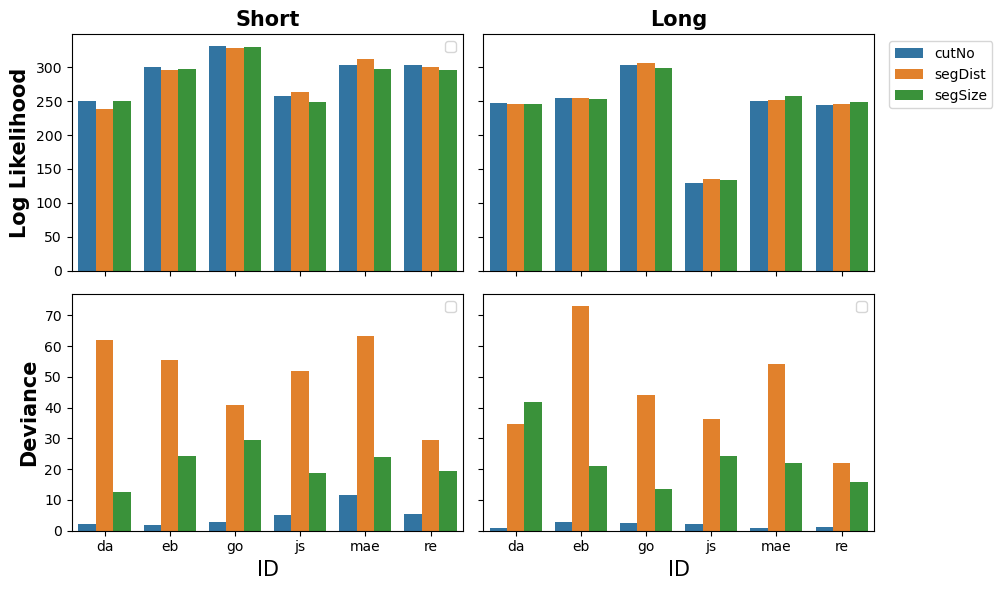

In [6]:
fig, ax = plt.subplots(2,2, figsize = (10,6), sharey='row', sharex= True)

sns.barplot(data = logLike.loc[logLike['expTime'] == 1], x = 'id', y = 'logLike', hue = 'predictor', ax = ax[0,0])
ax[0,0].set_title('Short', fontweight = 'bold', fontsize = 15)
ax[0,0].legend('')
ax[0,0].set_ylabel('Log Likelihood', fontweight = 'bold', fontsize = 15)
ax[0,0].set_xlabel('')

sns.barplot(data = logLike.loc[logLike['expTime'] == 2], x = 'id', y = 'logLike', hue = 'predictor', ax = ax[0,1])
ax[0,1].set_title('Long', fontweight = 'bold', fontsize = 15)
ax[0,1].set_ylabel('')
ax[0,1].legend(loc = 'upper right', bbox_to_anchor=(1.32, 1))
ax[0,1].set_xlabel('')

trgt_df = dev.loc[dev['expTime'] == 1]
sns.barplot(data = trgt_df, x ='id', y = 'dev', hue ='pred', ax=ax[1,0])
ax[1,0].legend('')
ax[1,0].set_ylabel('Deviance', fontweight = 'bold', fontsize = 15)
ax[1,0].set_xlabel('ID', fontsize = 15)

trgt_df = dev.loc[dev['expTime'] == 2]
sns.barplot(data = trgt_df, x ='id', y = 'dev', hue ='pred', ax=ax[1,1])
ax[1,1].legend('')
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('ID', fontsize = 15)

plt.tight_layout()

figname = 'figs/'+'logLike_dev_all.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)



## With calculation

In [7]:

colnames = ['x', 'da_y_short', 'da_y_long', 'eb_y_short', 'eb_y_long', 'go_y_short', 'go_y_long', 'mae_y_short', 'mae_y_long', 'js_y_short', 'js_y_long', 're_y_short', 're_y_long']
file_pth = 'data/cutNo_psychFit.csv'
cutNoPlt = pd.read_csv(file_pth, header=None).T
cutNoPlt.columns = colnames


colnames = ['da_x', 'da_y_short', 'da_y_long', 'eb_x', 'eb_y_short', 'eb_y_long', 'go_x', 'go_y_short', 'go_y_long', 'mae_x', 'mae_y_short', 'mae_y_long', 'js_x', 'js_y_short', 'js_y_long', 're_x', 're_y_short', 're_y_long']
file_pth = 'data/segDist_psychFit.csv'
segDistPlt = pd.read_csv(file_pth, header=None).T
segDistPlt.columns = colnames

file_pth = 'data/segSize_psychFit.csv'
segSizePlt = pd.read_csv(file_pth, header=None).T
segSizePlt.columns = colnames




In [8]:
file_pth ='data/all.csv'
df = pd.read_csv(file_pth)
df['eff_label'] = pd.cut(x=df['effortAll'], bins=[0, 0.048, 0.06, 13],
                     labels=['Easy', 'Normal', 'Difficult'])

### SegDist

In [9]:
participants = ['da', 'eb', 'go', 'mae', 'js', 're']

logLikeSegDist = np.zeros((len(participants),1))

for id in range(len(participants)):
    
    participantId = participants[id]
    trgt_df = df.loc[(df['participantID'] == participantId),:]
    rng = len(trgt_df)

    # Initialize required values
    correct = trgt_df.correct.values
    segDist = trgt_df.segCentDist.values
    expTime = trgt_df.expCond.values

    likelihood = 0
    for i in range(rng):
    
        # retrieve the participant and expTime specific X and Ys
        trgtXid = id*3                

        if expTime[i] == 1:
            trgtYid = trgtXid + 1
        else:
            trgtYid = trgtXid + 2

        X = segDistPlt.iloc[:,trgtXid]    
        Y = segDistPlt.iloc[:,trgtYid]    
        
        # Compute probability        
        idx = find_closest_number(X, segDist[i])
        if correct[i] == 1:
            prob = Y[idx]
        else:
            prob = 1 - Y[idx]

        # Compute total log likelihood
        likelihood = likelihood + np.log(prob)

    logLikeSegDist[id] = likelihood

### SegSize

In [10]:
participants = ['da', 'eb', 'go', 'mae', 'js', 're']

logLikeSegSize = np.zeros((len(participants),1))

for id in range(len(participants)):
    
    participantId = participants[id]
    trgt_df = df.loc[(df['participantID'] == participantId),:]
    rng = len(trgt_df)

    # Initialize required values
    correct = trgt_df.correct.values
    segDist = trgt_df.segSize.values
    expTime = trgt_df.expCond.values

    likelihood = 0
    for i in range(rng):
    
        # retrieve the participant and expTime specific X and Ys
        trgtXid = id*3                

        if expTime[i] == 1:
            trgtYid = trgtXid + 1
        else:
            trgtYid = trgtXid + 2

        X = segSizePlt.iloc[:,trgtXid]    
        Y = segSizePlt.iloc[:,trgtYid]    
        
        # Compute probability        
        idx = find_closest_number(X, segDist[i])
        if correct[i] == 1:
            prob = Y[idx]
        else:
            prob = 1 - Y[idx]

        # Compute total log likelihood
        likelihood = likelihood + np.log(prob)

    logLikeSegSize[id] = likelihood

### CutNo

In [11]:
participants = ['da', 'eb', 'go', 'mae', 'js', 're']

logLikeCutNo = np.zeros((len(participants),1))

for id in range(len(participants)):
    
    participantId = participants[id]
    trgt_df = df.loc[(df['participantID'] == participantId),:]
    rng = len(trgt_df)

    # Initialize required values
    correct = trgt_df.correct.values
    segDist = trgt_df.cutNo.values
    expTime = trgt_df.expCond.values

    likelihood = 0
    for i in range(rng):
    
        # retrieve the participant and expTime specific X and Ys
        trgtXid = 0             
        
        if expTime[i] == 1:
            trgtYid = (id*2) + 1
        else:
            trgtYid = (id*2) + 2

        X = cutNoPlt.iloc[:,trgtXid]    
        Y = cutNoPlt.iloc[:,trgtYid]    
        
        # Compute probability        
        idx = find_closest_number(X, segDist[i])
        if correct[i] == 1:
            prob = Y[idx]
        else:
            prob = 1 - Y[idx]

        # Compute total log likelihood
        likelihood = likelihood + np.log(prob)

    logLikeCutNo[id] = likelihood

### Combining and Plotting Results

In [12]:
participants = ['da', 'eb', 'go', 'mae', 'js', 're']

pred = (['cutNo']*len(participants))
pred.extend(['segSize']*len(participants))
pred.extend(['segDist']*len(participants))


logLike = np.concatenate((logLikeCutNo, logLikeSegDist,logLikeSegSize))

logLike = logLikeCutNo.T[0].tolist()
logLike.extend(logLikeSegDist.T[0].tolist())
logLike.extend(logLikeSegSize.T[0].tolist())

dict = {}
dict['id'] = participants*3
dict['pred'] = pred
dict['logLike'] = logLike

logLikeDf = pd.DataFrame.from_dict(dict)
logLikeDf['logLike'] = logLikeDf['logLike']*-1

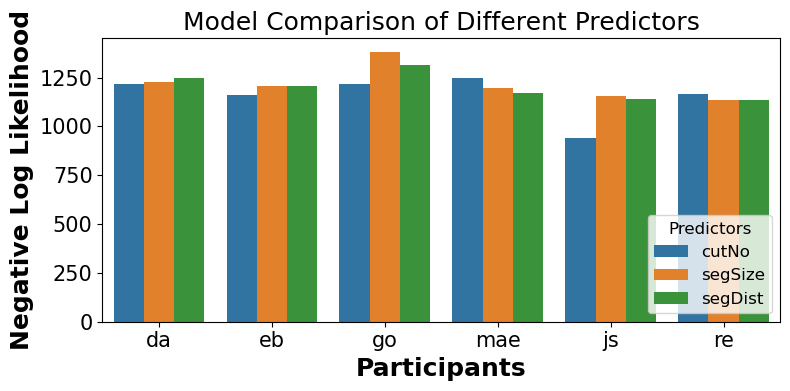

In [13]:
fig,ax = plt.subplots(figsize = (8,4))
ax = sns.barplot(data = logLikeDf, x = 'id', y = 'logLike', hue = 'pred')

ax.legend(loc = 'lower right', title='Predictors', title_fontsize='large', prop={'size':12})
ax.set_ylabel('Negative Log Likelihood', fontsize=18,fontweight='bold' )
ax.set_xlabel('Participants', fontsize=18,fontweight='bold')
ax.set_title('Model Comparison of Different Predictors', fontsize=18)
ax.tick_params(axis='both', labelsize=15)
plt.tight_layout()

figname = 'figs/' +'psych_modelComp.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


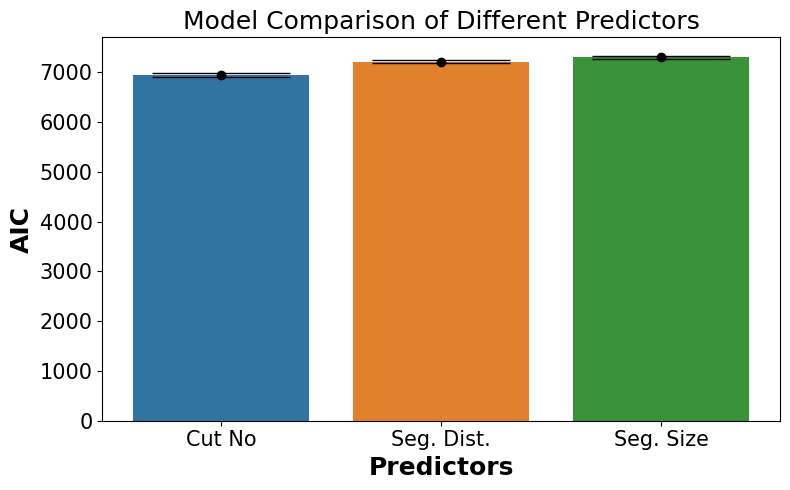

In [14]:
trgtDf = logLikeDf.groupby(['pred'], as_index=False).sum()
err = logLikeDf.groupby(['pred'], as_index=False).sem()

fig,ax = plt.subplots(figsize = (8,5))
sns.barplot(trgtDf['pred'], trgtDf['logLike'])
ax.errorbar(trgtDf['pred'], trgtDf['logLike'], yerr=err['logLike'], fmt="o", color="k", capsize=50)



ax.set_ylabel('AIC', fontsize=18,fontweight='bold' )
ax.set_xlabel('Predictors', fontsize=18,fontweight='bold')
ax.set_xticklabels(['Cut No', 'Seg. Dist.', 'Seg. Size'])
ax.set_title('Model Comparison of Different Predictors', fontsize=18)
ax.tick_params(axis='both', labelsize=15)
plt.tight_layout()

figname = 'figs/' +'psych_modelCompAgg.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

In [15]:
logLikeDf

,id,pred,logLike
0,da,cutNo,1215.670825
1,eb,cutNo,1160.446295
2,go,cutNo,1215.975249
3,mae,cutNo,1246.369789
4,js,cutNo,942.809295
5,re,cutNo,1163.406983
6,da,segSize,1226.752781
7,eb,segSize,1208.856380
8,go,segSize,1381.828960
9,mae,segSize,1194.293836


# Psychometric Function

/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_34139/3866511750.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_xticklabels((np.flip(axes[i,j].get_xticks()).astype(int)));
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_34139/3866511750.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_xticklabels((np.flip(axes[i,j].get_xticks()).astype(int)));
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_34139/3866511750.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_xticklabels((np.flip(axes[i,j].get_xticks()).astype(int)));
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_34139/3866511750.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_xticklabels((np.flip(axes[i,j].get_xticks()).astype(int)));
/var/folders/zg/xkfchz8d7w7g72p8t57_91100000gn/T/ipykernel_34139

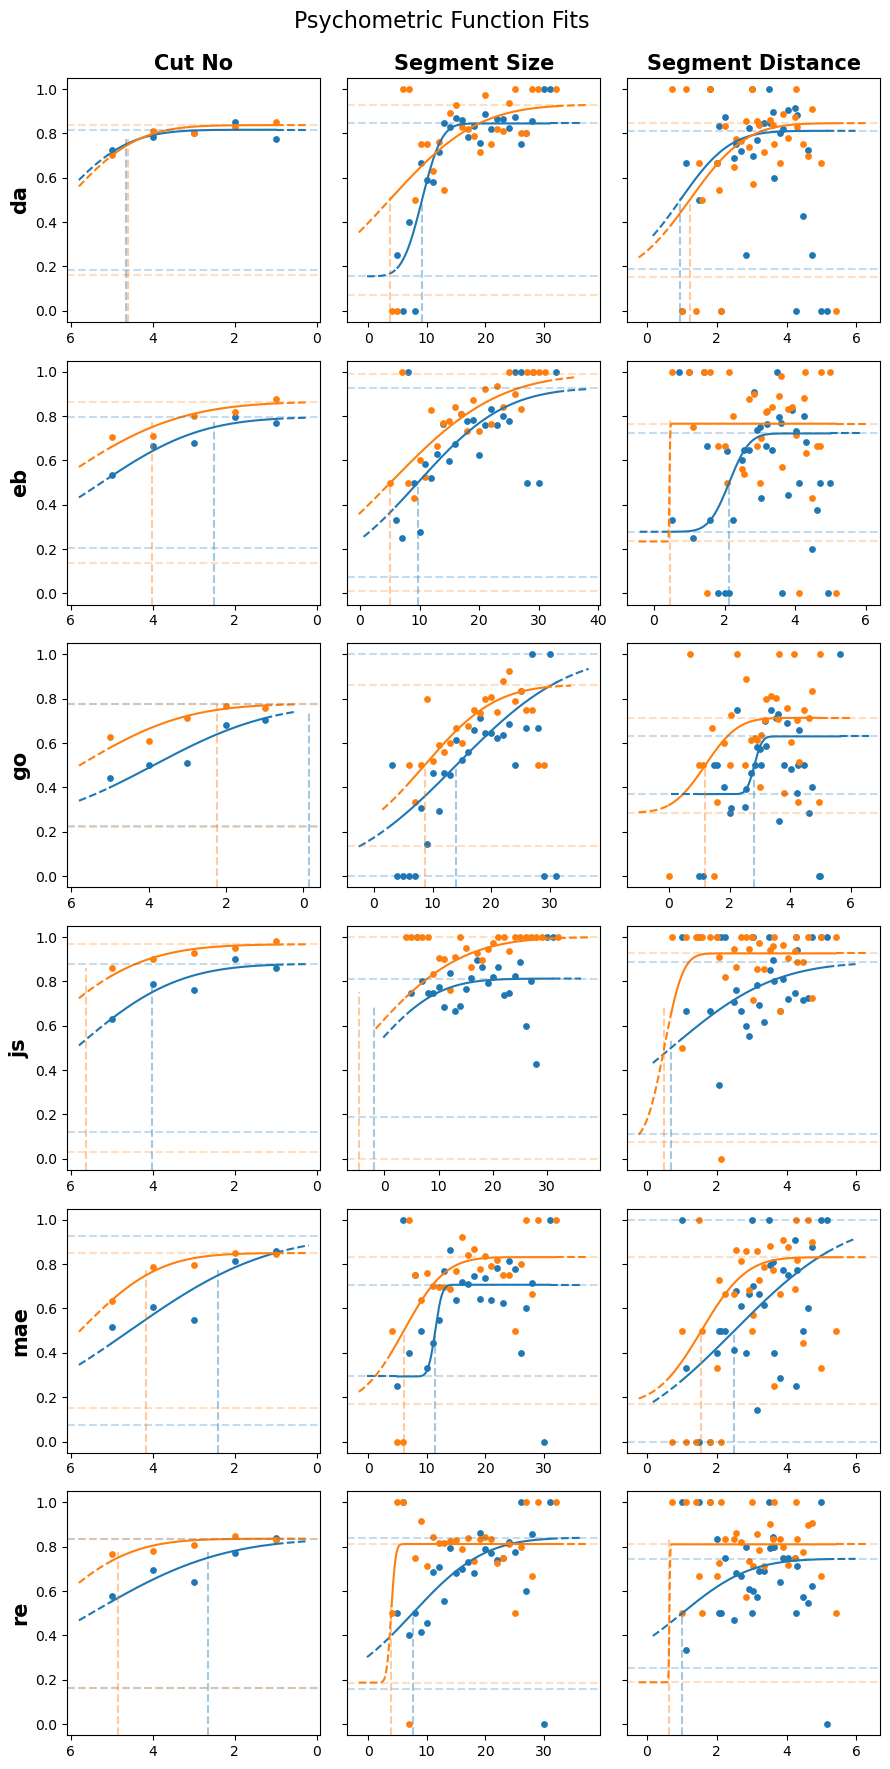

In [16]:

preds = ['cutNo', 'segSize', 'segDist']
predNames =  ['Cut No', 'Segment Size', 'Segment Distance']

participants = ['da', 'eb', 'go', 'js', 'mae', 're']
idNum = len(participants)

fig, axes = plt.subplots(idNum,3, figsize = (9,18),sharey=True)
#axes = axes.ravel()


for j in range(len(preds)):
    pred = preds[j]
    mat_fname = 'data/psych_' + pred + '.mat'
    container = sio.loadmat(mat_fname)

    for i in range(idNum):
        id = participants[i]
        
        # Plot curves
        axes[i,j].plot(container['plotData'][0][i]['shortXplt'][0], container['plotData'][0][i]['shortYplt'][0], color = 'tab:blue') # short
        axes[i,j].plot(container['plotData'][0][i]['longXplt'][0], container['plotData'][0][i]['longYplt'][0], color = 'tab:orange') # long 
        
        axes[i,j].plot(container['plotData'][0][i]['dshd1shortX'][0], container['plotData'][0][i]['dshd1shortY'][0], color = 'tab:blue', linestyle = '--') # short
        axes[i,j].plot(container['plotData'][0][i]['dshd1longX'][0], container['plotData'][0][i]['dshd1longY'][0], color = 'tab:orange', linestyle = '--') # long 

        axes[i,j].plot(container['plotData'][0][i]['dshd2shortX'][0], container['plotData'][0][i]['dshd2shortY'][0], color = 'tab:blue', linestyle = '--') # short
        axes[i,j].plot(container['plotData'][0][i]['dshd2longX'][0], container['plotData'][0][i]['dshd2longY'][0], color = 'tab:orange', linestyle = '--') # long 
            

        # Plot lower asymptotes
        axes[i,j].axhline(container['plotData'][0][i]['asymp1shortY'][0,0],ls = '--', color = 'tab:blue', alpha = 0.25)    
        axes[i,j].axhline(container['plotData'][0][i]['asymp1longY'][0,0],ls = '--', color = 'tab:orange', alpha = 0.25)    

        # Plot lower asymptotes
        axes[i,j].axhline(container['plotData'][0][i]['asymp2shortY'][0,0],ls = '--', color = 'tab:blue', alpha = 0.25)    
        axes[i,j].axhline(container['plotData'][0][i]['asymp2longY'][0,0],ls = '--', color = 'tab:orange', alpha = 0.25)    
        

        # Plot data
        axes[i,j].scatter(container['plotData'][0][i]['shortXdata'][0], container['plotData'][0][i]['shortYdata'][0], color = 'tab:blue', s = 15) # short
        axes[i,j].scatter(container['plotData'][0][i]['longX'][0], container['plotData'][0][i]['longY'][0], color = 'tab:orange', s = 15) # long 

        # Plot thresholds
        y_lim_id = find_closest_number(container['plotData'][0][i]['shortXplt'][0], container['plotData'][0][i]['thrShort'][0,0])
        y_lim = container['plotData'][0][i]['shortYplt'][0,y_lim_id]
        axes[i,j].axvline(x=container['plotData'][0][i]['thrShort'][0],ymax=y_lim, linestyle='--', color = 'tab:blue', alpha = 0.4) # short

        y_lim_id = find_closest_number(container['plotData'][0][i]['longXplt'][0], container['plotData'][0][i]['thrLong'][0,0])
        y_lim = container['plotData'][0][i]['longYplt'][0,y_lim_id]
        axes[i,j].axvline(x=container['plotData'][0][i]['thrLong'][0], ymax=y_lim, linestyle='--', color = 'tab:orange', alpha = 0.4) # long

        #axes[i,0].set_title('{}'.format(id), style = 'italic', fontsize = 15)
        axes[0,j].set_title('{}'.format(predNames[j]),fontsize = 15, fontweight="bold")
        axes[i,0].set_ylabel('{}'.format(id), fontsize = 15, fontweight="bold")
        
        if pred == 'cutNo':
           axes[i,j].set_xticklabels((np.flip(axes[i,j].get_xticks()).astype(int)));          

        #axes[i,j].set_aspect('equal', adjustable='box')
fig.suptitle("Psychometric Function Fits \n", fontsize = 16)
plt.tight_layout()

figname = 'figs/psych_fits.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

In [17]:
thr_dict = {}
thr_dict['id'] = []
thr_dict['pred'] = []
thr_dict['short'] = []
thr_dict['long'] = []


for j in range(len(preds)):
    pred = preds[j]
    mat_fname = 'data/psych_' + pred + '.mat'
    container = sio.loadmat(mat_fname)            

    for i in range(idNum):
        id = participants[i]
        
        thr_dict['pred'].append(pred)
        thr_dict['id'].append(id)
        
        thr_short = container['plotData'][0][i]['thrShort'][0][0]
        thr_long = container['plotData'][0][i]['thrLong'][0][0]
        
        thr_dict['short'].append(thr_short)
        thr_dict['long'].append(thr_long)


thrDF = pd.DataFrame.from_dict(thr_dict)


print(thrDF.to_latex())

\begin{tabular}{lllrr}
\toprule
{} &   id &     pred &      short &      long \\
\midrule
0  &   da &    cutNo &   1.337748 &  1.407849 \\
1  &   eb &    cutNo &   3.492886 &  1.978581 \\
2  &   go &    cutNo &   6.137583 &  3.779563 \\
3  &   js &    cutNo &   1.971463 &  0.381695 \\
4  &  mae &    cutNo &   3.595919 &  1.836959 \\
5  &   re &    cutNo &   3.334828 &  1.142791 \\
6  &   da &  segSize &   9.182048 &  3.642508 \\
7  &   eb &  segSize &   9.731037 &  5.115287 \\
8  &   go &  segSize &  14.008968 &  8.615146 \\
9  &   js &  segSize &  -1.944792 & -4.698285 \\
10 &  mae &  segSize &  11.435349 &  6.084914 \\
11 &   re &  segSize &   7.580310 &  3.915072 \\
12 &   da &  segDist &   0.957261 &  1.225682 \\
13 &   eb &  segDist &   2.132436 &  0.442295 \\
14 &   go &  segDist &   2.819398 &  1.194295 \\
15 &   js &  segDist &   0.689212 &  0.496435 \\
16 &  mae &  segDist &   2.507805 &  1.562439 \\
17 &   re &  segDist &   1.007435 &  0.646122 \\
\bottomrule
\end{tabular}



# Posterior Densities

In [18]:
file_pth ='data/all.csv'
df = pd.read_csv(file_pth)
df['eff_label'] = pd.cut(x=df['effortAll'], bins=[0, 0.048, 0.06, 13],
                     labels=['Easy', 'Normal', 'Difficult'])


## Seg Size

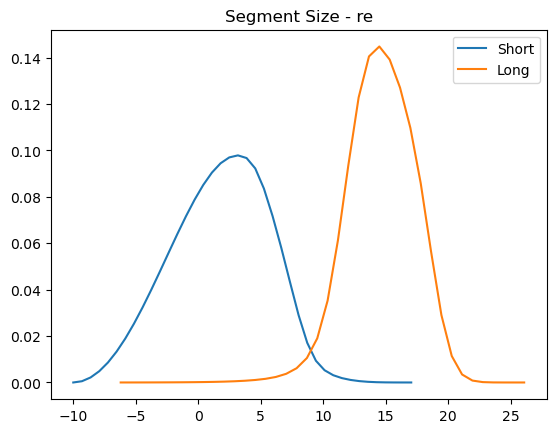

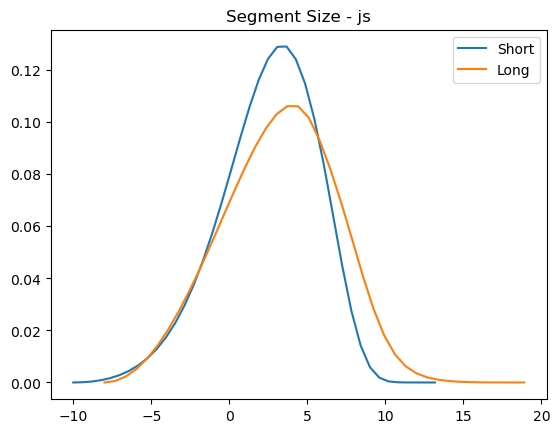

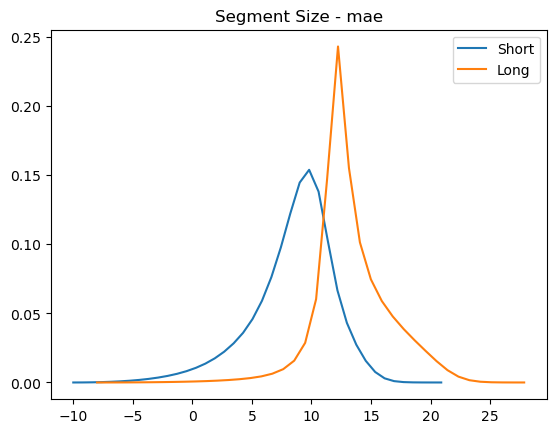

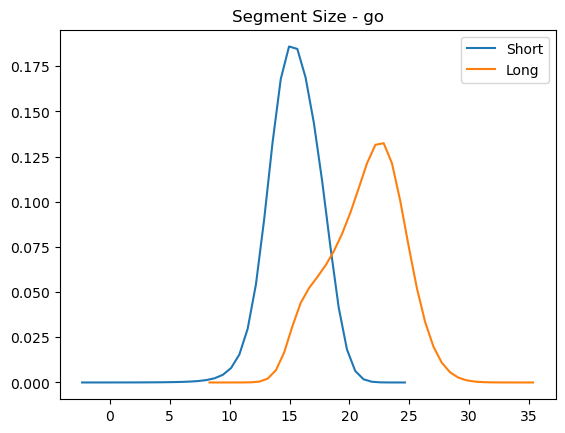

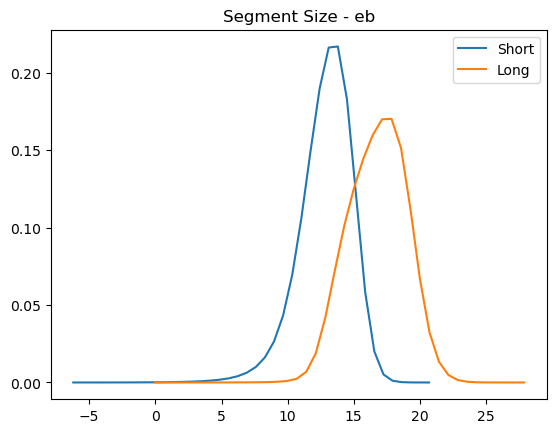

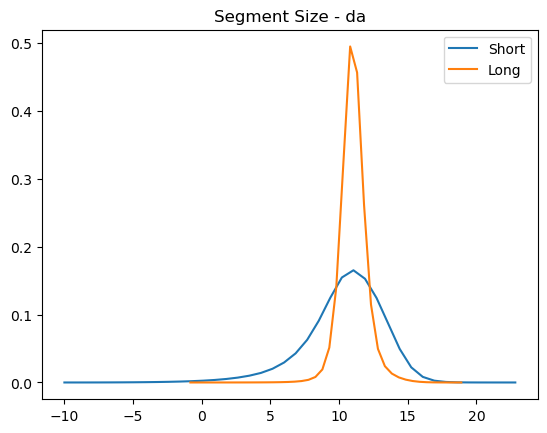

In [19]:
participants = ['re', 'js', 'mae', 'go', 'eb', 'da']
segSizeDict = {}

for participantId in participants:    

    # Load corresponding data
    file_pth ='data/{}/psych_segSize_{}.csv'.format(participantId, participantId)
    segSize_psych = pd.read_csv(file_pth, header=None)
    segSize_psych = segSize_psych.rename(columns={0: 'x_short', 1: 'y_short', 2:'x_long', 3:'y_long'})

    trgt_df = df.loc[(df['participantID'] == participantId) & (df['control'] == 0), :]
    nTrials = len(trgt_df)

    # Plot marginal densities
    plt.figure()
    plt.plot(segSize_psych['x_short'], segSize_psych['y_short'], label = 'Short')
    plt.plot(segSize_psych['x_long'], segSize_psych['y_long'], label = 'Long')    
    plt.legend()
    plt.title('Segment Size - {}'.format(participantId))

    # Compute prob. difference
    probs = np.ones((nTrials,2)) * np.nan

    for i in range(nTrials):
        expCond = trgt_df.iloc[i].expCond
        segSize = trgt_df.iloc[i].segSize

        # Sample for both short and long conditions
        for expTime in range(1,3):            
            if expTime == 1:
                trgtDistX = 'x_short'
                trgtDistY = 'y_short'
            else:
                trgtDistX = 'x_long'
                trgtDistY = 'y_long'

            id = find_closest_number(segSize_psych[trgtDistX], segSize)
            p = segSize_psych[trgtDistY].values[id]

            # Sample
            #ans = np.random.binomial(1, p)

            # Store
            probs[i,expTime-1] = p
        

    # Long - Short Exp Time
    pDiff = probs[:,1] - probs[:,0]

    pred = (pDiff > 0)*1
    
    segSizeDict[participantId] = []
    segSizeDict[participantId].append(pred)
    

## Seg Distance

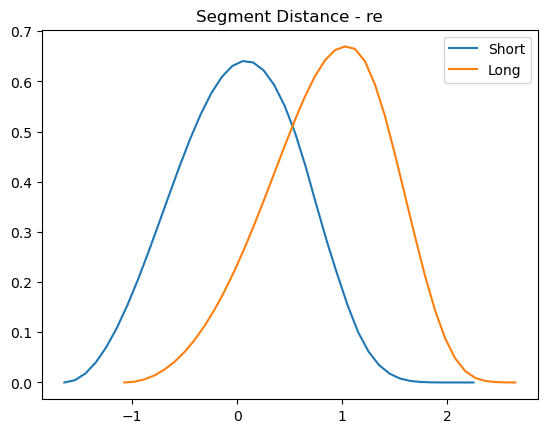

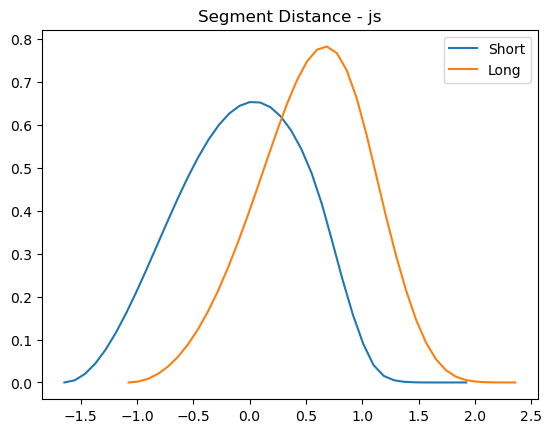

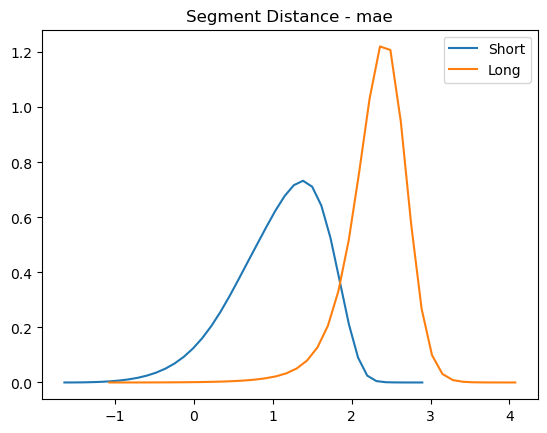

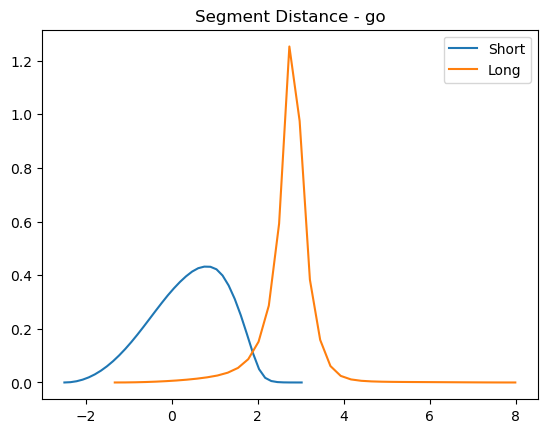

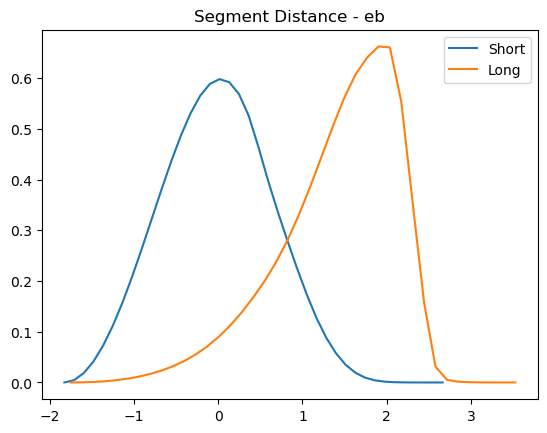

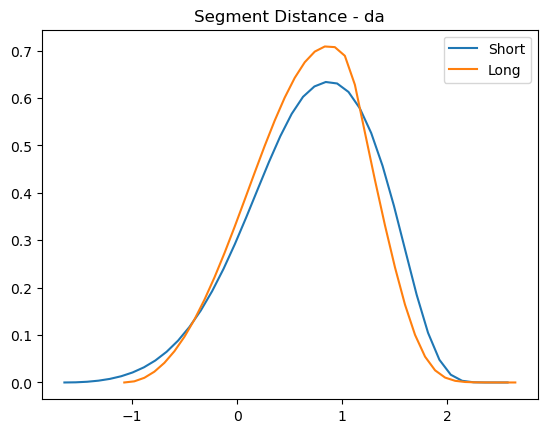

In [20]:
participants = ['re', 'js', 'mae', 'go', 'eb', 'da']
segDistDict = {}

for participantId in participants:    

    # Load corresponding data
    file_pth ='data/{}/psych_segDist_{}.csv'.format(participantId, participantId)
    segSize_psych = pd.read_csv(file_pth, header=None)
    segSize_psych = segSize_psych.rename(columns={0: 'x_short', 1: 'y_short', 2:'x_long', 3:'y_long'})

    trgt_df = df.loc[(df['participantID'] == participantId) & (df['control'] == 0), :]
    nTrials = len(trgt_df)

    # Plot marginal densities
    plt.figure()
    plt.plot(segSize_psych['x_short'], segSize_psych['y_short'], label = 'Short')
    plt.plot(segSize_psych['x_long'], segSize_psych['y_long'], label = 'Long')    
    plt.legend()
    plt.title('Segment Distance - {}'.format(participantId))

    # Compute prob. difference
    probs = np.ones((nTrials,2)) * np.nan

    for i in range(nTrials):
        expCond = trgt_df.iloc[i].expCond
        segCentDist = trgt_df.iloc[i].segCentDist

        # Sample for both short and long conditions
        for expTime in range(1,3):            
            if expTime == 1:
                trgtDistX = 'x_short'
                trgtDistY = 'y_short'
            else:
                trgtDistX = 'x_long'
                trgtDistY = 'y_long'

            id = find_closest_number(segSize_psych[trgtDistX], segCentDist)
            p = segSize_psych[trgtDistY].values[id]

            # Sample
            #ans = np.random.binomial(1, p)

            # Store
            probs[i,expTime-1] = p
        

    # Long - Short Exp Time
    pDiff = probs[:,1] - probs[:,0]

    pred = (pDiff > 0)*1

    segDistDict[participantId] = []
    segDistDict[participantId].append(pred)
    
    

## Cut No

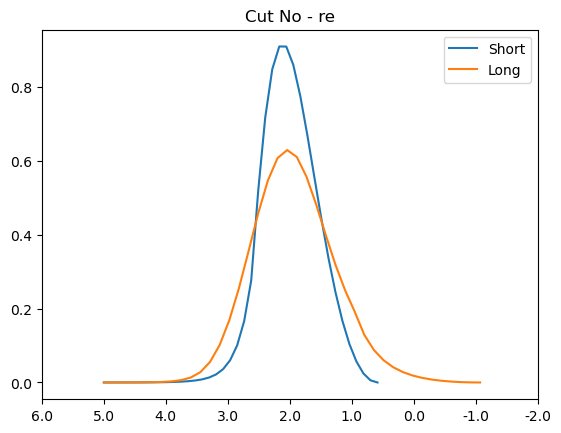

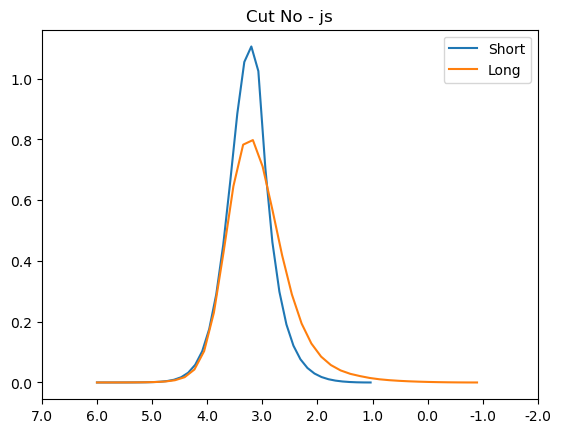

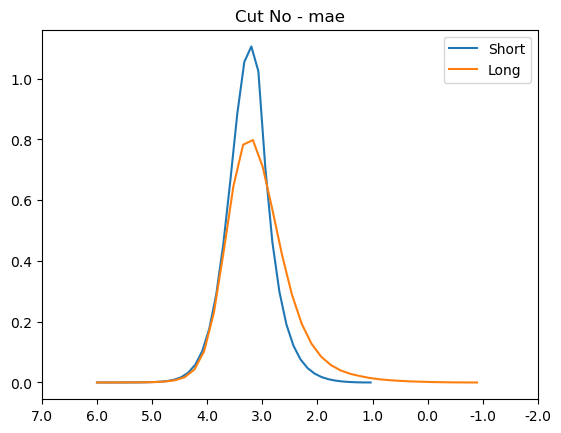

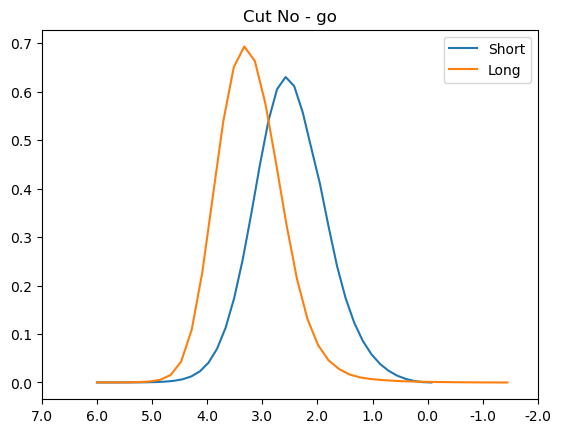

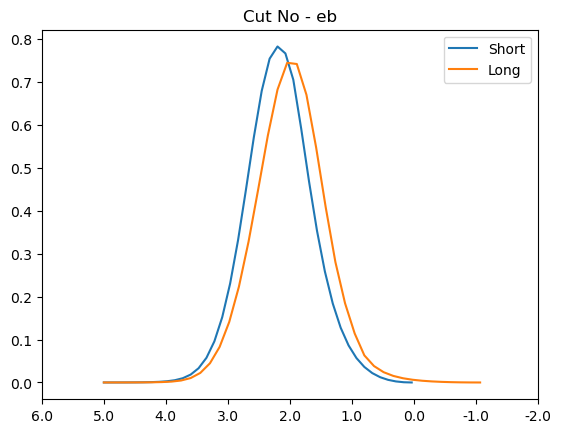

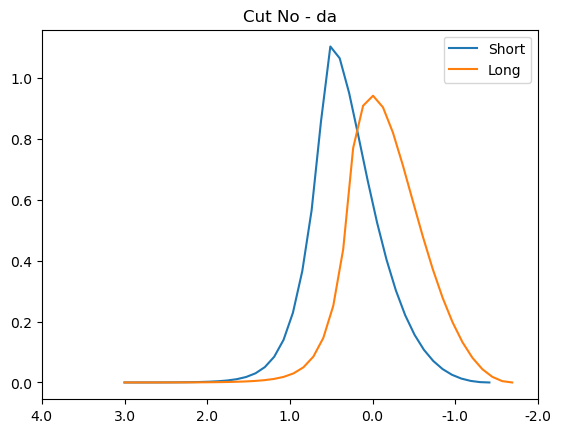

In [21]:
participants = ['re', 'js', 'mae', 'go', 'eb', 'da']
cutNoDict = {}

for participantId in participants:    

    # Load corresponding data
    file_pth ='data/{}/psych_cutNo_{}.csv'.format(participantId, participantId)
    psych_cutNp = pd.read_csv(file_pth, header=None)
    psych_cutNp = psych_cutNp.rename(columns={0: 'x_short', 1: 'y_short', 2:'x_long', 3:'y_long'})

    trgt_df = df.loc[(df['participantID'] == participantId) & (df['control'] == 0), :]
    nTrials = len(trgt_df)

    # Plot marginal densities
    fig, ax = plt.subplots()
    ax.plot(np.flip(psych_cutNp['x_short']), psych_cutNp['y_short'], label = 'Short')    
    ax.plot(np.flip(psych_cutNp['x_long']), psych_cutNp['y_long'], label = 'Long')        
    ax.set_xticks(np.flip(ax.get_xticks()))
    ax.set_xticklabels(np.flip(ax.get_xticks()));
    plt.legend()
    plt.title('Cut No - {}'.format(participantId))
    


    # Compute prob. difference
    probs = np.ones((nTrials,2)) * np.nan

    for i in range(nTrials):
        expCond = trgt_df.iloc[i].expCond
        cutNo = trgt_df.iloc[i].cutNo

        # Sample for both short and long conditions
        for expTime in range(1,3):            
            if expTime == 1:
                trgtDistX = 'x_short'
                trgtDistY = 'y_short'
            else:
                trgtDistX = 'x_long'
                trgtDistY = 'y_long'

            id = find_closest_number(psych_cutNp[trgtDistX], cutNo)
            p = psych_cutNp[trgtDistY].values[id]

            # Sample
            #ans = np.random.binomial(1, p)

            # Store
            probs[i,expTime-1] = p
        

    # Long - Short Exp Time
    pDiff = probs[:,1] - probs[:,0]

    pred = (pDiff > 0)*1
    cutNoDict[participantId] = []
    cutNoDict[participantId].append(pred)
    

In [22]:
probs = [0]
i = 0
integ = 0
while i < (len(segSize_psych)-2):                    
   # for short and long exposure time
   area = (segSize_psych.loc[i + 1,'x_short'] - segSize_psych.loc[i,'x_short']) * segSize_psych.loc[i + 1, 'y_short'] 
   integ = area + integ
   probs.append(area)

   i = i + 1

probs.append(1-integ)

# Sampling

## Seg Size

In [23]:
NUM_ROLLS = 500

participants = ['re', 'js', 'mae', 'go', 'eb', 'da']
segSizeDict = {}

diffDict = {}
diffDict['larger'] = []

table = {}

table['pred'] =[]
table['id'] =[]
table['t'] =[]
table['p'] =[]

for id in participants:
    # Load corresponding data
    file_pth ='data/{}/psych_segSize_{}.csv'.format(id, id)
    segSize_psych = pd.read_csv(file_pth, header=None)
    segSize_psych = segSize_psych.rename(columns={0: 'x_short', 1: 'y_short', 2:'x_long', 3:'y_long'})

    # compute probabilities from densities
    compute_probs(segSize_psych)

    # Prepare variables for the sampling    
    values_short = segSize_psych['x_short']
    probs_short = segSize_psych['prob_short']

    values_long = segSize_psych['x_long']
    probs_long = segSize_psych['prob_long']
        
    # Draw a weighted sample
    sample_short = np.random.choice(values_short, NUM_ROLLS, p=probs_short)
    sample_long = np.random.choice(values_long, NUM_ROLLS, p=probs_long)

    # Numpy arrays containing counts for each side
    x_short, count = np.unique(sample_short, return_counts=True)
    probs_short = count / len(sample_short)
    
    x_long, count = np.unique(sample_long, return_counts=True)        
    probs_long = count / len(sample_long)
    

    # Store samplings in dictionary
    segSizeDict[id] = []    
    segSizeDict[id].append(probs_short)
    segSizeDict[id].append(x_short)
    segSizeDict[id].append(sample_short)
    
    segSizeDict[id].append(probs_long)    
    segSizeDict[id].append(x_long)
    segSizeDict[id].append(sample_long)
    
    segSizeDf = pd.DataFrame(segSizeDict).T
    segSizeDf = segSizeDf.rename(columns={0:'short_prob', 1:'short_x', 2:"short_sample", 3:"long_prob", 4:"long_x", 5:"long_sample"})

    # Compute statistical analyses
    segSizeDiff = segSizeDict[id][5] - segSizeDict[id][2]
    t_statistic, p_value = stats.ttest_1samp(segSizeDiff, 0)
    
    table['pred'].append('segSize')
    table['t'].append(t_statistic)
    table['p'].append(p_value)
    table['id'].append(id)

    tableDf = pd.DataFrame(table).set_index('id')

    segSizeDf = pd.concat([tableDf, segSizeDf], axis= 1)
    diff = segSizeDf['long_sample'] - segSizeDf['short_sample']
    segSizeDf['diff'] = diff        
        

segSizeDf.index.name = 'id'
segSizeDf = segSizeDf.reset_index()


for i in range(len(segSizeDf)):
    diffDict['larger'].append(segSizeDf.iloc[i,10] > 0)

diff = pd.DataFrame.from_dict(diffDict)
segSizeDf['larger'] = diff
segSizeDf['mean'] = 0

for i in range(len(participants)):
    val = (segSizeDf.iloc[i,10]>0).mean()        
    segSizeDf.iloc[i,12] = val


## Seg Dist

In [24]:
participants = ['re', 'js', 'mae', 'go', 'eb', 'da']
segDistDict = {}

table = {}

table['pred'] =[]
table['id'] =[]
table['t'] =[]
table['p'] =[]

diffDict = {}
diffDict['larger'] = []

for id in participants:
    # Load corresponding data
    file_pth ='data/{}/psych_segDist_{}.csv'.format(id, id)
    segDist_psych = pd.read_csv(file_pth, header=None)
    segDist_psych = segDist_psych.rename(columns={0: 'x_short', 1: 'y_short', 2:'x_long', 3:'y_long'})

    # compute probabilities from densities
    compute_probs(segDist_psych)

    # Prepare variables for the sampling    
    values_short = segDist_psych['x_short']
    values_long = segDist_psych['x_long']

    probs_short = segDist_psych['prob_short']
    probs_long = segDist_psych['prob_long']

    # Draw a weighted sample
    sample_short = np.random.choice(values_short, NUM_ROLLS, p=probs_short)
    sample_long = np.random.choice(values_long, NUM_ROLLS, p=probs_long)

    # Numpy arrays containing counts for each side
    x_short, count = np.unique(sample_short, return_counts=True)
    probs_short = count / len(sample_short)

    x_long, count = np.unique(sample_long, return_counts=True)    
    probs_long = count / len(sample_long)

    # Store samplings in dictionary
    segDistDict[id] = []    
    segDistDict[id].append(probs_short)
    segDistDict[id].append(x_short)
    segDistDict[id].append(sample_short)
    
    segDistDict[id].append(probs_long)
    segDistDict[id].append(x_long)
    segDistDict[id].append(sample_long) 
    

    segDistDf = pd.DataFrame(segDistDict).T
    segDistDf = segDistDf.rename(columns={0:'short_prob', 1:'short_x', 2:"short_sample", 3:"long_prob", 4:"long_x", 5:"long_sample"})

    # Compute statistical analyses
    segDistDiff = segDistDict[id][5] - segDistDict[id][2]
    t_statistic, p_value = stats.ttest_1samp(segDistDiff, 0)
    
    table['pred'].append('segDist')
    table['t'].append(t_statistic)
    table['p'].append(p_value)
    table['id'].append(id)

    tableDf = pd.DataFrame(table).set_index('id')

    segDistDf = pd.concat([tableDf, segDistDf], axis= 1)
    segDistDf['diff'] = segDistDf['long_sample'] - segDistDf['short_sample']   
    segDistDf['larger'] = (segDistDf['long_sample'] - segDistDf['short_sample'])*1


segDistDf.index.name = 'id'
segDistDf = segDistDf.reset_index()

for i in range(len(segDistDf)):
    diffDict['larger'].append(segDistDf.iloc[i,10] > 0)

diff = pd.DataFrame.from_dict(diffDict)
segDistDf['larger'] = diff
segDistDf['mean'] = 0

for i in range(len(participants)):
    val = (segDistDf.iloc[i,10]>0).mean()        
    segDistDf.iloc[i,12] = val


## Cut No

In [25]:
participants = ['re', 'js', 'mae', 'go', 'eb', 'da']
cutNoDict = {}

table = {}

table['pred'] =[]
table['id'] =[]
table['t'] =[]
table['p'] =[]

diffDict = {}
diffDict['larger'] = []

for id in participants:
    # Load corresponding data
    file_pth ='data/{}/psych_cutNo_{}.csv'.format(id, id)
    cutNo_psych = pd.read_csv(file_pth, header=None)
    cutNo_psych = cutNo_psych.rename(columns={0: 'x_short', 1: 'y_short', 2:'x_long', 3:'y_long'})

    # compute probabilities from densities
    compute_probs(cutNo_psych)

    # Prepare variables for the sampling    
    values_short = cutNo_psych['x_short']
    probs_short = cutNo_psych['prob_short']
    
    values_long = cutNo_psych['x_long']    
    probs_long = cutNo_psych['prob_long']

    # Draw a weighted sample
    sample_short = np.random.choice(values_short, NUM_ROLLS, p=probs_short)
    sample_long = np.random.choice(values_long, NUM_ROLLS, p=probs_long)
    
    # Numpy arrays containing counts for each side
    x_short, count = np.unique(sample_short, return_counts=True)
    probs_short = count / len(sample_short)

    x_long, count = np.unique(sample_long, return_counts=True)
    probs_long = count / len(sample_long)

    # Store samplings in dictionary
    cutNoDict[id] = []    
    cutNoDict[id].append(probs_short)
    cutNoDict[id].append(x_short)
    cutNoDict[id].append(sample_short)
    
    cutNoDict[id].append(probs_long)
    cutNoDict[id].append(x_long)
    cutNoDict[id].append(sample_long)    
        
    cutNoDf = pd.DataFrame(cutNoDict).T
    cutNoDf = cutNoDf.rename(columns={0:'short_prob', 1:'short_x', 2:"short_sample", 3:"long_prob", 4:"long_x", 5:"long_sample"})


    # Compute statistical analyses
    cutNoDiff = cutNoDict[id][5] - cutNoDict[id][2]
    t_statistic, p_value = stats.ttest_1samp(cutNoDiff, 0)
    
    table['pred'].append('cutNo')
    table['t'].append(t_statistic)
    table['p'].append(p_value)
    table['id'].append(id)

    tableDf = pd.DataFrame(table).set_index('id')

    cutNoDf = pd.concat([tableDf, cutNoDf], axis= 1)
    cutNoDf['diff'] = cutNoDf['long_sample'] - cutNoDf['short_sample']   


cutNoDf.index.name = 'id'
cutNoDf = cutNoDf.reset_index()

for i in range(len(cutNoDf)):
    diffDict['larger'].append(cutNoDf.iloc[i,10] > 0)

diff = pd.DataFrame.from_dict(diffDict)
cutNoDf['larger'] = diff
cutNoDf['mean'] = 0

for i in range(len(participants)):
    val = (cutNoDf.iloc[i,10]>0).mean()        
    cutNoDf.iloc[i,12] = val

# Results

In [26]:
sampleDf = pd.concat([segSizeDf, segDistDf, cutNoDf])
sampleDf = sampleDf.reset_index()
sampleDf = sampleDf.drop(columns='index')

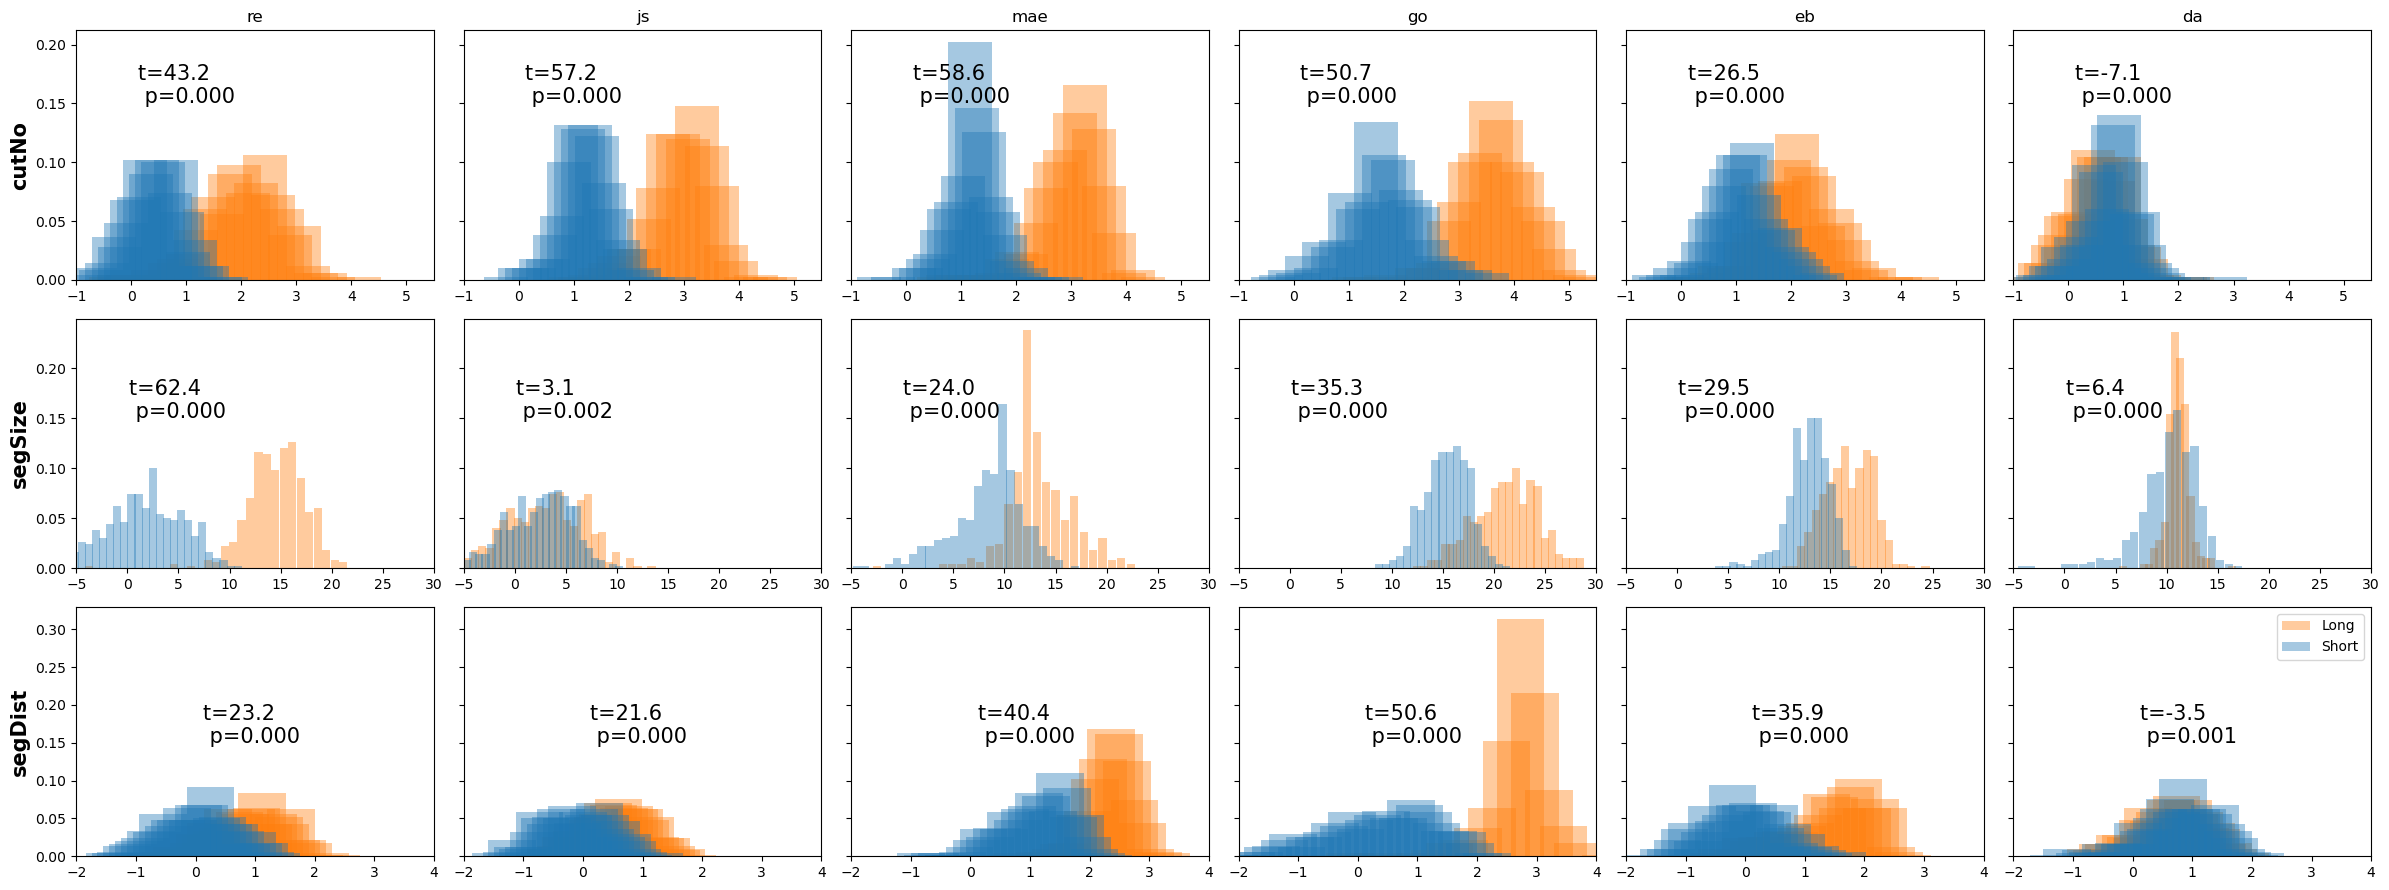

In [27]:
preds = ['cutNo', 'segSize', 'segDist']

fig, axes = plt.subplots(3,6, figsize=(24,9), sharey='row', sharex=False)
for j in range(len(preds)):
    pred = preds[j]
    for i in range(len(cutNoDf)):
        trgt_df = sampleDf.loc[sampleDf['pred'] == pred]
        
        axes[j,i].bar(trgt_df.iloc[i].long_x, trgt_df.iloc[i].long_prob, color='tab:orange', alpha = 0.4, label = "Long")
        axes[j,i].bar(trgt_df.iloc[i].short_x, trgt_df.iloc[i].short_prob, color = 'tab:blue', alpha = 0.4, label = "Short")  
        
        t =  trgt_df.iloc[i].t
        p = trgt_df.iloc[i].p

        axes[j,i].text(0.12, 0.15, 't={:.1f} \n p={:.3f}'.format(t,p) , fontsize=15)

        if j == 0:
            axes[j,i].set_title(participants[i])
            axes[j,i].set_xlim([-1,5.5])
        elif j == 1:
            axes[j,i].set_xlim([-5,30])
        elif j == 2:
            axes[j,i].set_xlim([-2,4])
    # Set label
    axes[j,0].set_ylabel(pred, fontsize = 15, fontweight="bold")

axes[-1,-1].legend()
plt.tight_layout()

figname = 'figs/'+'sampling_all.png'
plt.savefig(figname, facecolor='white', transparent=False, dpi = 300)

In [37]:
file_pth = 'data/sampling.pkl'
sampleDf.to_pickle(file_pth)

In [29]:
probFinal= []
for i in range(len(preds)):
    trgt_df = sampleDf.loc[sampleDf['pred'] == preds[i],'mean']
    probFinal.append(np.prod(trgt_df))

probFinal

[0.27517560280769227, 0.24391090430074366, 0.26488023334819194]

<AxesSubplot:xlabel='id', ylabel='mean'>

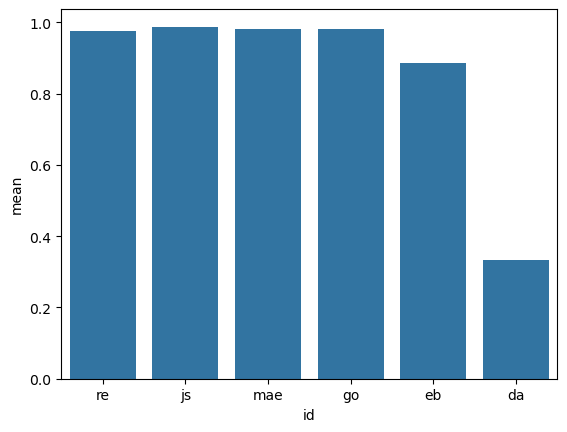

In [30]:
sns.barplot(data = sampleDf.loc[sampleDf['pred'] == 'cutNo'], x = 'id', y = 'mean', color='tab:blue')

<AxesSubplot:xlabel='id', ylabel='mean'>

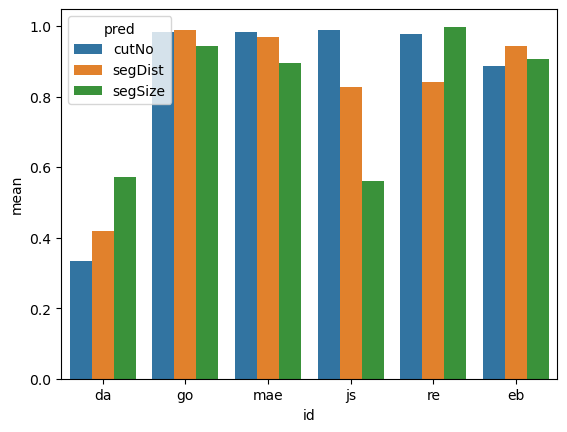

In [31]:
sns.barplot(data = sampleDf.sort_values(by='pred'), x = 'id', y = 'mean', hue='pred')

In [32]:
sampleDf.loc[:,['id','pred','mean']]

,id,pred,mean
0,re,segSize,0.998
1,js,segSize,0.560
2,mae,segSize,0.894
3,go,segSize,0.942
4,eb,segSize,0.906
5,da,segSize,0.572
6,re,segDist,0.842
7,js,segDist,0.828
8,mae,segDist,0.970
9,go,segDist,0.990


In [33]:
print(sampleDf.pivot(index = 'id',columns='pred', values = 'mean').reset_index().to_latex())

\begin{tabular}{llrrr}
\toprule
pred &   id &  cutNo &  segDist &  segSize \\
\midrule
0 &   da &  0.334 &    0.420 &    0.572 \\
1 &   eb &  0.886 &    0.942 &    0.906 \\
2 &   go &  0.982 &    0.990 &    0.942 \\
3 &   js &  0.988 &    0.828 &    0.560 \\
4 &  mae &  0.982 &    0.970 &    0.894 \\
5 &   re &  0.976 &    0.842 &    0.998 \\
\bottomrule
\end{tabular}

